# Function

In [8]:
'''
Input: img - numpy array 224 * 224
Output: Function returns a dictionary 'dict'
Output: dict[thr] - dictionary what contain few characteristics of image, 
when all pixels less than threshold were deleted
Geometry characteristics:  
    Area - number of yellow pixels
    Hor-dist - distance between leftmost and rightmost yellow pixels
    Ver-dist - distance between upmost and downmost yellow pixels
    Contour_hor_slice - length of contour when we sliced image horizontaly
    Full_area_hor_slice - area what surrounded by 'horizontal' contour
    Contour_ver_slice - length of contour when we sliced image vertically
    Full_area_ver_slice - area what surrounded by 'vertical' contour

'''
def EstimateImageBFS(img):
    dict = {}

    thr = 120
    bfs_neighb = 5
    rest_neighb = 3
    thresholds = []
    for t in range(3, 6):
        thresholds.append([thr, bfs_neighb, rest_neighb])
        thr -= 5
        rest_neighb += 1

    for ind in range(len(thresholds)):
        threshold = thresholds[ind][0]
        img_t = (img >= threshold)
        #if ind + 1 == len(thresholds):
        #    img = (img >= threshold)
            
        dict[threshold] = []

        grid = img_t.reshape(7, 32, 7, 32).sum(axis=(1, 3))
        mxind = np.unravel_index(grid.argmax(), grid.shape)

        # BFS
        directions = []
        range_of_neigh = thresholds[ind][1]
        for i in range(-range_of_neigh, range_of_neigh + 1):
            val = range_of_neigh - abs(i)
            for j in range(-val, val + 1):
                if abs(i) + abs(j) != 0:
                    directions.append([i, j])

        used = {}
        queue = []
        for i in range(32 * mxind[0], 32 * (mxind[0] + 1)):
            for j in range(32 * mxind[1], 32 * (mxind[1] + 1)):
                #print(i, j)
                if img_t[i][j] >= 1:
                    queue.append([i, j])
                    used[i, j] = True
                    for dir in directions:
                        ndir = [i + dir[0], j + dir[1]]
                        if max(ndir) >= 224 or min(ndir) < 0 or img_t[ndir[0]][ndir[1]] < 1:
                            continue
                        if (ndir[0], ndir[1]) in used.keys():
                            if used[ndir[0], ndir[1]] == True:
                                used[ndir[0], ndir[1]] = abs(dir[0]) + abs(dir[1])
                            else:
                                used[ndir[0], ndir[1]] = min(used[ndir[0], ndir[1]], abs(dir[0]) + abs(dir[1]))

        head = 0
        while head < len(queue):
            for dir in directions:
                ndir = [queue[head][0] + dir[0], queue[head][1] + dir[1]]

                if max(ndir) >= 224 or min(ndir) < 0 or img_t[ndir[0]][ndir[1]] < 1:
                    continue

                if (ndir[0], ndir[1]) in used.keys():
                    if used[ndir[0], ndir[1]] == True:
                        used[ndir[0], ndir[1]] = abs(dir[0]) + abs(dir[1])
                    else:
                        used[ndir[0], ndir[1]] = min(used[ndir[0], ndir[1]], abs(dir[0]) + abs(dir[1]))
                    continue

                # else append
                used[ndir[0], ndir[1]] = abs(dir[0]) + abs(dir[1])
                queue.append(ndir)
            head += 1

        #nimg = np.zeros((224, 224))
        rest = []
        left_most = -1
        right_most = -1
        up_most = -1
        down_most = -1
        min_in_col = [-1 for i in range(224)]
        max_in_col = [-1 for i in range(224)]
        min_in_row = [-1 for i in range(224)]
        max_in_row = [-1 for i in range(224)]
        for i in used.keys():
            if used[i] == True or used[i] >= thresholds[ind][2]:
                rest.append(i)
            else:
                #nimg[i[0]][i[1]] = 1
                if left_most == -1 or i[0] < left_most:
                    left_most = i[0]
                if right_most == -1 or i[0] > right_most:
                    right_most = i[0]
                if up_most == -1 or i[1] < up_most:
                    up_most = i[1]
                if down_most == -1 or i[1] > down_most:
                    down_most = i[1]

                if max_in_row[i[0]] == -1 or max_in_row[i[0]] < i[1]:
                    max_in_row[i[0]] = i[1]
                if min_in_row[i[0]] == -1 or min_in_row[i[0]] > i[1]:
                    min_in_row[i[0]] = i[1]

                if max_in_col[i[1]] == -1 or max_in_col[i[1]] < i[0]:
                    max_in_col[i[1]] = i[0]
                if min_in_col[i[1]] == -1 or min_in_col[i[1]] > i[0]:
                    min_in_col[i[1]] = i[0]

        for i in rest:
            del used[i[0], i[1]]

        contour_hor_slice = 0
        full_area_hor_slice = 0
        for row in range(up_most, down_most + 1):
            #nimg[row][max_in_row[row]] = 1
            #nimg[row][min_in_row[row]] = 1
            full_area_hor_slice += max_in_row[row] - min_in_row[row]
            if row != up_most:
                contour_hor_slice += abs(max_in_row[row - 1] - max_in_row[row])
                contour_hor_slice += abs(min_in_row[row - 1] - min_in_row[row])

        contour_ver_slice = 0
        full_area_ver_slice = 0
        for col in range(left_most, right_most + 1):
            #nimg[min_in_col[col]][col] = 1
            #nimg[max_in_col[col]][col] = 1
            full_area_ver_slice += max_in_col[col] - min_in_col[col]
            if col != left_most:
                contour_ver_slice += abs(max_in_col[col - 1] - max_in_col[col])
                contour_ver_slice += abs(min_in_col[col - 1] - min_in_col[col])

        Char = {}
        Char["Area"] = len(used)
        Char["Hor_dist"] = right_most - left_most
        Char["Ver_dist"] = down_most - up_most
        Char["Contour_hor_slice"] = contour_hor_slice
        Char["Full_area_hor_slice"] = full_area_hor_slice
        Char["Contour_ver_slice"] = contour_ver_slice
        Char["Full_area_ver_slice"] = full_area_ver_slice
        #print(len(used))
        #print(Char)
        dict[threshold] = Char.values()

    return dict


# Preload to show how to use this function

In [3]:
import torch
import pandas as pd
import warnings
from PIL import Image
import numpy as np
import json
import os
import cv2
import albumentations as A
import IPython.display
from matplotlib import pyplot as plt
import PIL
import seaborn as sns
import scipy
import sklearn
from sklearn import tree

from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook, tqdm
import random

from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook, tqdm
import random

warnings.filterwarnings('ignore')

In [4]:
class IdaoTrainDataset(Dataset):
    def __init__(self, root, index_path, label_converter_path, transforms=None, RGB=False):
        super().__init__()
        self._root = root
        self._index = pd.read_csv(index_path)
        self._img_names = os.listdir(root)
        #print("index = ", self._index)
        #print("len = ", len(self._index))
        self._index["gen_label"] = self._index.apply(lambda t : str(t.nuc_type) + str(t.energy), axis=1)
        #print("index[gen_label] = ", self._index["gen_label"][0])
        with open(label_converter_path, "r") as f:
            self._label_converter = json.load(f)

        self._transforms = transforms
        self._RGB = RGB
        self.label_counter = Counter(self._index.gen_label.values.tolist())

    def __getitem__(self, idx):
        img_name, nuc_type, energy, gen_label = self._index.iloc[idx]
        path = os.path.join(self._root, str(img_name))

        if self._RGB:
            img = Image.open(os.path.join(self._root, img_name)).convert("RGB")
        else:
            img = Image.open(os.path.join(self._root, img_name))

        img = np.array(img)
        if self._transforms:
            img = torch.FloatTensor(self._transforms(image=img)["image"])
        gen_label = self._label_converter[gen_label]
        nuc_type = self._label_converter[nuc_type]
        #energy = self._label_converter[str(energy)]
        return {
            "image" : img.permute(2, 0, 1) if self._RGB else img,
            "_img_names" : str(img_name),
            "nuc_type" : nuc_type,
            "energy" : energy,
            "gen_label" : gen_label,
            "path" : path
        }

    def sample_classes_and_plot(self):
        images = dict()

        for gen_label in ["ER{}".format(i) for i in [1, 3, 6, 10, 20, 30]] + ["NR{}".format(i) for i in [1, 3, 6, 10, 20, 30]]:
            img_name, nuc_type, energy, _ = self._index[self._index.gen_label == gen_label].sample(n=1).iloc[0]
            #print(self._index[self._index.gen_label == gen_label].sample(n=1).iloc[0])
            images[gen_label] = os.path.join(self._root, img_name)

        fig = plt.figure(figsize=(15, 15))
        #fig = plt.figure()
        #plt.subplots
        columns = 6
        rows = 2
        ax = []

        for i, gen_label in enumerate(["ER{}".format(i) for i in [1, 3, 6, 10, 20, 30]] + ["NR{}".format(i) for i in [1, 3, 6, 10, 20, 30]]):
            img_name = images[gen_label]
            image = Image.open(img_name)
            image = np.array(image)
            if self._transforms:
                image = self._transforms(image=image)["image"]
            ax.append(fig.add_subplot(rows, columns, i+1))
            t = EstimateImage(image)
            ax[-1].set_title(gen_label + " " + str(t[:len(t) - 1]))
            nimage = t[-1]
            #plt.plot(0, 0)
            plt.imshow(nimage)
            #print(gen_label, EstimateImage(image))
        plt.show()
        return

    def make_plot_for_all(self):
        images = dict()

        for gen_label in ["ER{}".format(i) for i in [3, 10, 30]] + ["NR{}".format(i) for i in [1, 6, 20]]:
            images[gen_label] = []
            for t in range(15):
                img_name, nuc_type, energy, _ = self._index[self._index.gen_label == gen_label].sample(n=1).iloc[0]
                images[gen_label].append(os.path.join(self._root, img_name))

        sz = 15
        fig = plt.figure(figsize=(sz, sz))
        #fig = plt.figure()
        #plt.subplots
        columns = 6
        rows = 2
        ax = []

        #figtogether = plt.figure(figsize=(50, 50))

        colors = ["c", "g", "b", "y", "m", "r"]
        #colors = ["b", "b", "b", "r", "r", "r"]
        for i, gen_label in enumerate(["ER{}".format(i) for i in [3, 10, 30]] + ["NR{}".format(i) for i in [1, 6, 20]]):
            points = []
            avg = [0, 0]
            for j in images[gen_label]:
                img_name = j
                image = Image.open(img_name)
                image = np.array(image)
                if self._transforms:
                    image = self._transforms(image=image)["image"]
                t = EstimateImage(image)
                points.append([t[0], t[1]])
                for k in [0, 1]:
                    avg[k] += t[k]

            for k in [0, 1]:
                avg[k] //= len(points)
            if len(ax) == 0:
                ax.append(fig.add_subplot(rows, columns, i+1))
            #ax[-1].set_title(gen_label + " " + str(avg))
            ax[-1].set_title("ER - blue, NR - red")
            ax[-1].set(xlabel = "count of yellow pixels (how much it is visible)", ylabel = "variance (circle is closer to 0 than no circle)")

            #nimage = t[-1]
            plt.xlim(0, 500)
            plt.ylim(0, 100)
            #plt.plot(0, 0)
            for point in points:
                plt.plot(point[0], point[1], colors[i] + "o")

            #plt.imshow(nimage)
            #print(gen_label, EstimateImage(image))
        plt.show()
        return

    def make_plot_for_each(self):
        images = dict()

        for gen_label in ["ER{}".format(i) for i in [1, 3, 6, 10, 20, 30]] + ["NR{}".format(i) for i in [1, 3, 6, 10, 20, 30]]:
            img_name, nuc_type, energy, _ = self._index[self._index.gen_label == gen_label].sample(n = 1).iloc[0]
            images[gen_label] = (os.path.join(self._root, img_name))

        sz = 15
        fig = plt.figure(figsize=(sz, sz))
        #fig = plt.figure()
        #plt.subplots
        columns = 6
        rows = 2
        ax = []

        for i, gen_label in enumerate(["ER{}".format(i) for i in [1, 3, 6, 10, 20, 30]] + ["NR{}".format(i) for i in [1, 3, 6, 10, 20, 30]]):
            img_name = images[gen_label]
            image = Image.open(img_name)
            image = np.array(image)
            if self._transforms:
                image = self._transforms(image=image)["image"]
            ax.append(fig.add_subplot(rows, columns, i+1))
            t = EstimateImage(image)
            ax[-1].set_title(gen_label + " " + str(t[:len(t) - 1]))
            nimage = t[-1]
            #plt.plot(0, 0)
            plt.imshow(nimage)
            #print(gen_label, EstimateImage(image))
        plt.show()
        #
        return

    def __len__(self):
        return len(self._index)


class IdaoTestDataset(Dataset):
    def __init__(self, root, transforms=None, RGB=False):
        super().__init__()
        self._root = root
        self._img_names = os.listdir(root)
        self._transforms = transforms
        self._RGB = RGB


    def __getitem__(self, idx):
        img_name = self._img_names[idx]
        if self._RGB:
            img = Image.open(os.path.join(self._root, img_name)).convert("RGB")
        else:
            img = Image.open(os.path.join(self._root, img_name))
        tensor = np.array(img)
        if self._transforms:
            img = torch.FloatTensor(self._transforms(image=img)["image"])
        return {
                "image" : img.permute(2, 0, 1) if self._RGB else img,
                "path" : os.path.join(self._root, img_name)
        }

    def __len__(self):
        return len(self._img_names)

    def sample_and_plot(self):
        image_name = random.sample(self._img_names, k=1)[0]
        image = Image.open(os.path.join(self._root, image_name))
        image = np.array(image)
        if self._transforms:
            image = self._transforms(image=image)["image"]
        plt.imshow(image)
        plt.title(image_name)
        return

def show_img(img):
    plt.imshow(img)
    plt.title('my picture')
    plt.show()
    return


In [5]:
sz = 224
transforms = A.Compose([
    A.CenterCrop(width=sz, height=sz),
    A.Solarize(threshold=128, p=1.0)
    #A.ToFloat(10)
    ])

In [6]:
train_dataset = IdaoTrainDataset("idao_dataset/train",
                                 "utils_data/index.csv",
                                 "utils_data/label_converter.json",
                                 transforms=transforms, RGB=False)

# Example of usage

{120: dict_values([125, 19, 18, 68, 211, 306, 209]), 115: dict_values([230, 21, 22, 326, 291, 87, 275]), 110: dict_values([356, 28, 26, 592, 423, 814, 426])}


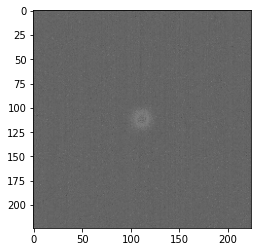

In [9]:
import sys
plt.imshow(train_dataset[100]['image'], cmap='gray', vmin=0, vmax=255.)
print(EstimateImageBFS(train_dataset[100]['image']))